**1. Analyze and describe the SQL database in terms of relations, columns/features,
size, completeness, etc.**

In [7]:
import sqlite3 as lite
import pandas as pd
import seaborn as sns

**2. Extract the SQL database in a Python environment. Describe the conversion
process and how the database is deserialized in Python.**

Below is a code sample for extracting data from a SQLite database. Using the built in 'sqlite' module for python, we can open a connection by calling the 'connect()' function that points to a "*.db" file.

The returned connection object, named 'con', represents the connection to the on-disk database.

In [25]:
con = lite.connect('cycling_big.db')
query = "SELECT * FROM race_results"
df = pd.read_sql_query(query, con)

if (con != None):
    print("Succesfully loaded at: ", con)

Succesfully loaded at:  <sqlite3.Connection object at 0x7fe9c90bd6c0>


In [ ]:
df.head

In [ ]:
df.describe(include='all')

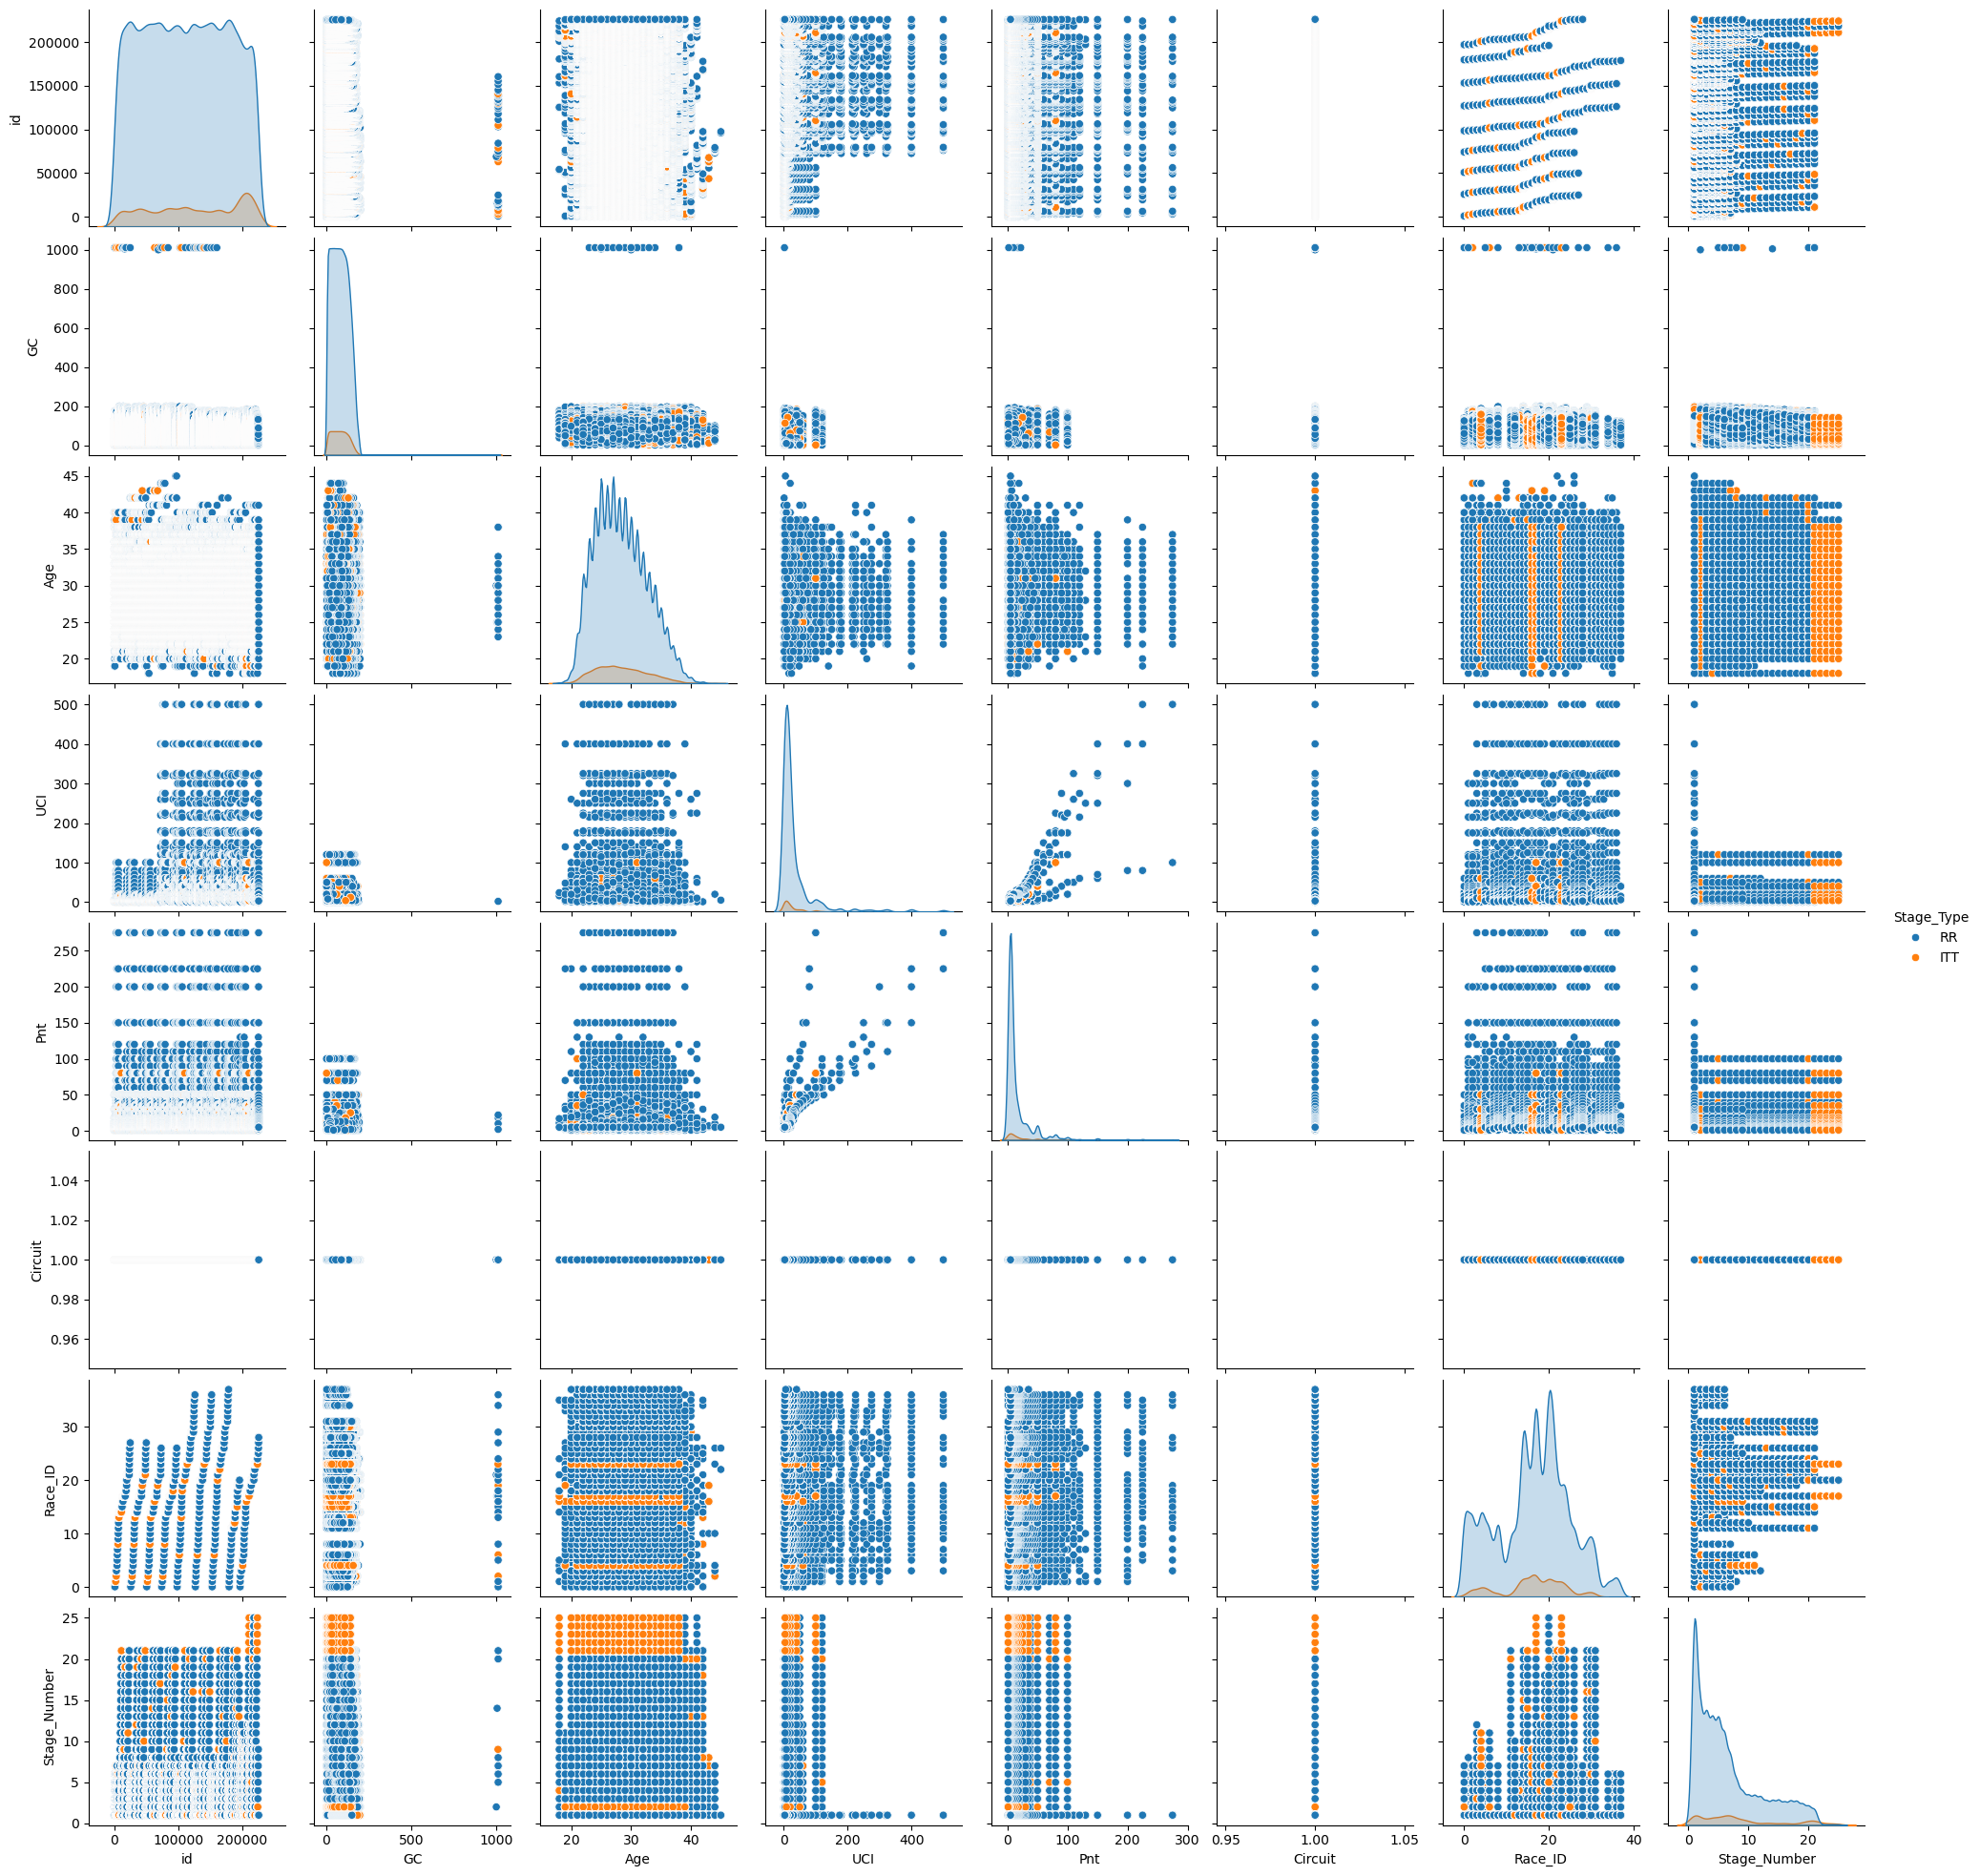

In [9]:
sns.pairplot(df, hue='Stage_Type')